In [5]:
import json
import numpy as np
import pandas as pd
import seaborn as sns
from itertools import cycle

import tensorflow as tf
import torch
from pytorch_tabnet.tab_model import TabNetClassifier

from sklearn import svm
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import RFE
from sklearn.preprocessing import label_binarize
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, roc_curve,auc, f1_score, accuracy_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold

%matplotlib inline

np.random.seed(0)
print("Jupyter online")

Jupyter online


In [6]:
#Make sure to run the Label_creation.ipynb file first.

def open_json(jsonfile):                                            #Function to open Json files
    jsonopen = open(jsonfile)
    jfile = json.load(jsonopen)
    jsonopen.close()
    x = pd.DataFrame(jfile)
    return x

def framenames(path, fps):
    frames = np.arange(0, 900*fps+1, 24).tolist()                   #900 seconds = 15 minutes
    startname = 'frame'
    endname = '_keypoints.json'
    frames = frames[1:]
    framelist = []
    for i in frames:
        framelist.append(path+startname+str(i-1)+endname)           #select 1 frame before
        framelist.append(path+startname+str(i)+endname)             #Select frame which is linked to groundtruth
        framelist.append(path+startname+str(i+1)+endname)           #select 1 frame after
    return(framelist)

def data_loader(framelist):
    pose1= []
    pose2= []
    count1 = 0                          #Counter to count how many skeletons there are, count1 = only 1 skeleton, etc.
    count2 = 0
    count3 = 0
    count4 = 0
    count5 = 0
    for jsonfile in framelist:          #Checks how many skeletons are overlaid per frame
        data = open_json(jsonfile)
        if len(data.index) == 1:
            s1 = data.iloc[0,:]
            s2 = data.iloc[0,:]         #add the same data as a dummy signer 2 since there is only 1 skeleton in the frame
            count1 += 1
        if len(data.index) == 2:
            s1 = data.iloc[0,:]
            s2 = data.iloc[1,:]
            count2 += 1
        if len(data.index) == 3:
            s1 = data.iloc[0,:]
            s2 = data.iloc[2,:]
            count3 += 1
        if len(data.index) == 4:       
            s1 = data.iloc[0,:]
            s2 = data.iloc[1,:]
            count4 += 1
        if len(data.index) == 5:
            s1 = data.iloc[0,:]
            s2 = data.iloc[1,:]
            print(jsonfile)
            count5 += 1

        #Assigning and dropping the right columns etc.  from the skeletons
        sig1 = s1["people"]
        sig2 = s2["people"]

        signer1poses = pd.DataFrame.from_dict(sig1, orient='index')
        signer2poses = pd.DataFrame.from_dict(sig2, orient='index')

        signer1 = signer1poses.iloc[1:5,:]
        signer2 = signer2poses.iloc[1:5,:]

        signer1 = signer1.drop(["face_keypoints_2d"])
        signer2 = signer2.drop(["face_keypoints_2d"])
        
        pose1.append(signer1)
        pose2.append(signer2)
    poses = pose1 + pose2
    print('There are '+str(count1)+' frames with 1 person in them')
    print('There are '+str(count2)+' frames with 2 persons in them')
    print('There are '+str(count3)+' frames with 3 persons in them')
    print('There are '+str(count4)+' frames with 4 persons in them')
    print('There are '+str(count5)+' frames with 5 persons in them')
    print()
    print('There are a total of '+str(len(framelist))+" frames")
    return poses

def scale(lst):                                 #custom scale function
    newdata = []
    for i,d in enumerate(lst):
        if d.any() > 0:
           newdata.append(d/500)                #500 because the videos are always with people around the center horizon of the frame and highest value encountered is max. 450. 
        else:
            newdata.append(d)
    return newdata


    #def scale(lst):                            #abandoned scale function
#    scaler = StandardScaler()
#    newdata = scaler.fit_transform(lst)
#    return newdata

def normalizer(lst,nmbr):                       #Function is not used
    fin = []
    norm = (nmbr*1.8)
    #assuming person 2 always sits on the right in the frame which gives him/her different y coordinates but similar x coordinates.
    z = np.array([norm,0])
    #normalize the y coordinate appropriately for person 1 so relative distances stay the same. 
    for i,d in enumerate(lst):
        if d.any() > 0:
            d = d-z
            fin.append(d)
        else:
            fin.append(d) 
    return fin

def pose_processor(poses):                                                      
    lengthp = len(poses)
    middle = lengthp/2
    p1 = poses[:int(middle)]
    p2 = poses[int(middle):]

    #Create confidenceintervals index
    confidenceintervals = np.arange(-1, 75, 3).tolist()      
    confidenceintervals = confidenceintervals[1:]
    #print(confidenceintervals)

    #Create x and y coordinates index
    coordinates = np.arange(0, 75, 1).tolist()
    cs1 = set(confidenceintervals)
    coorindex = [x for x in coordinates if x not in cs1]
    #print(coorindex)

    person1 = []
    for framepose in p1:                                        #framepose signer 1
        signer1 = pd.DataFrame(framepose) 
        skel1 = signer1.iloc[0,:]
        #Get confidence intervals for signer 1 and 2 per keypoint
        ci1 = [skel1[i] for i in confidenceintervals]
        #Get x and y coordinates for signer 1 and 2 per keypoint
        skelcoor1 = [skel1[i] for i in coorindex]
        sk1 = np.array_split(skelcoor1, 25)
        #Normalize on neck Y coordinate as neck position
        neck2 = sk1[1]
        newdata1 = sk1
        #newdata1 = scale(normalizer(sk1, neck2[0]))
        person1.append(newdata1)
        
    person2 = []
    for framepose in p2:                                        #framepose signer 2
        signer2 = pd.DataFrame(framepose) 
        skel2 = signer2.iloc[0,:]
        #Get confidence intervals for signer 1 and 2 per keypoint
        ci2 = [skel2[i] for i in confidenceintervals]
        #Get x and y coordinates for signer 1 and 2 per keypoint
        skelcoor2 = [skel2[i] for i in coorindex]
        sk2 = np.array_split(skelcoor2, 25)
        newdata2 = sk2
        #newdata2 = scale(sk2)
        person2.append(newdata2)
    #return sk1, sk2
    signers = person1 + person2
    return signers

def label_loader(labelspath):                                               #Loads the labels for the video from the label csv, make sure to run the Label_creation.ipynb file first.
    data = pd.read_csv(labelspath)
    data2 = data.iloc[:,3]
    labels = data2
    labels = np.array(labels)
    return labels

def frame_concat(poses):                                                      #Puts the information of 3 frames behind each other as one row with the info of 3 frames.
    poses = poses
    lengthp = len(poses)
    middle = lengthp/2
    p1 = poses[:int(middle)]
    p2 = poses[int(middle):]
    p1 = pd.DataFrame(p1)
    p2 = pd.DataFrame(p2)
    N = 3   
    #Thanks to Ted Manders for helping me with this nice loop, thank you bro
    new_df1 = []
    new_df2 = []
    # For every 3 rows
    for i in range(0, len(p1), 3):
       
        new_row1 = []
        subset1 = p1.iloc[[i, i+1, i+2]]
        # For every column
        for j in subset1:
            new_row1.append(subset1[j].tolist())
        new_row1 = np.array(new_row1)
        new_row1 = new_row1.flatten()
        new_df1.append(new_row1)

        new_row2 = []
        subset2 = p2.iloc[[i, i+1, i+2]]
        # For every column
        for j in subset2:
            new_row2.append(subset2[j].tolist())
        new_row2= np.array(new_row2)
        new_row2 = new_row2.flatten()
        new_df2.append(new_row2)  
    def_df1 = pd.DataFrame(new_df1)
    def_df2 = pd.DataFrame(new_df2)
    dataset = pd.concat([def_df1, def_df2], axis=1)

    #Normalize data squared min-max
    features_min = np.array(dataset).min()
    features_max = np.array(dataset).max()
    features = ((dataset - features_min) / (features_max - features_min))**2
    
    X = features.to_numpy()
    return X

def show_roc_plot(y_true, y_pred, i):                               #plots multiclass ROC plot for TabNet, copied and cusomized from: https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
    fold = str(i)
    n_classes = 4
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    lw = 2
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:,i], y_pred[:,i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure(figsize=(10,10))
    plt.plot(
        fpr["micro"],
        tpr["micro"],
        label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
        color="deeppink",
        linestyle=":",
        linewidth=4,
    )

    plt.plot(
        fpr["macro"],
        tpr["macro"],
        label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
        color="navy",
        linestyle=":",
        linewidth=4,
    )

    colors = cycle(["aqua", "darkorange", "cornflowerblue", "red"])
    for i, color in zip(range(n_classes), colors):
        plt.plot(
            fpr[i],
            tpr[i],
            color=color,
            lw=lw,
            label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
        )

    plt.plot([0, 1], [0, 1], "k--", lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Some extension of Receiver operating characteristic to multiclass")
    plt.legend(loc="lower right")
    #plt.savefig('ROC'+fold+'.png', bbox_inches='tight')
    plt.show()

def show_accuracy(clf_trainacc, clf_validacc):                      #Create accuracy plot for TabNet classifier
    plt.figure(figsize=(10,10))
    plt.plot(clf_trainacc[5:])
    plt.plot(clf_validacc[5:])
    plt.show()

def featureplot(featureslist, modelname):                                      #Create featureplot of top 10 most influential features per model
    plt.figure(figsize=(10,10))
    sns.barplot(x=featureslist.index[:10], y=featureslist[:10])

    print('Top 10 most influential feature column names:')
    print(featureslist.index[:10])
    print("Feature values:")
    print(featureslist[:10])

    plt.ylabel('Feature Importance Score')
    plt.xlabel('Feature name (numbers 0-299)')
    plt.title("Top 10 influential features "+modelname)
    plt.legend()
    plt.show()


def svmfeatureplot(cv_results, fold):
    plt.figure(figsize=(16,6))
    plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_test_f1_weighted"])
    plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_train_f1_weighted"])
    plt.xlabel("number of features")
    plt.ylabel("weighted f1 score")
    plt.title("Optimal Number of Features for SVM "+str(fold))
    plt.legend(["test score", "train score"], loc="upper left")
    plt.show()


#https://stackoverflow.com/questions/41592661/determining-the-most-contributing-features-for-svm-classifier-in-sklearn
def svmfeatureimportance(svmcoef, feature_names):
    if len(feature_names) != len(abs(svmcoef[0])):                      #Work in progress for svm feature importance if number of features is not equal to total number of available features.
        print(svmcoef)
        #print(x.nlargest(10).plot(kind='barh'))
    else:
        pd.Series(abs(svmcoef[0]), index=feature_names).nlargest(10).plot(kind='barh')

def svmrbfplot(perm_importance,feature_names, fold):                          #plots a plot based on importance of the Top 10 most influential features.
    plt.figure(figsize=(10,20))
    fig, ax = plt.subplots()
    features = np.array(feature_names)
    sorted_idx = perm_importance.importances_mean.argsort()
    xrbf = features[sorted_idx]
    yrbf = perm_importance.importances_mean[sorted_idx]

    print('Top 10 most influential feature column names:')
    print(xrbf[-10:])
    print("Feature values:")
    print(yrbf[-10:])
    
    p1 = ax.barh(xrbf[-10:], yrbf[-10:])
    ax.bar_label(p1,labels = xrbf[-10:], padding = 3)
    ax.set_title("Permutation Importance for SVM "+str(fold))
    plt.xlabel("Permutation Score")
    plt.ylabel("Label Name (0-299)")
    plt.show()


def finish_processing(path,fps,labelspath):
    framelist = framenames(path, fps)
    poses = data_loader(framelist)
    processedsk = pose_processor(poses)
    framedev = frame_concat(processedsk)
    #features = processedsk
    #labels = label_loader(labelspath)
    return framedev

In [7]:
#Select right video here by switching out hashtags

#path = 'D:\Videos thesis\KN5Jan7_poses\KN5Jan7_poses\\'         #Find and explain which features are important for signer diarization/ Turn taking problem as two classes.
path = 'D:\Videos thesis\PiKe4jan7_poses\PiKe4jan7_poses\\'
#path = 'D:\Videos thesis\ReKe_poses\ReKe10_poses\\'
#path = 'D:\Videos thesis\SuJu16_poses\SuJu16_poses\\'

fps = 24

#Select right labels here by switching out hashtags

#labelspath = 'D:\Videos thesis\KN5jan7_annotated.csv'
labelspath = 'D:\Videos thesis\PiKe4jan7_11juli2017_annotated.csv'
#labelspath = 'D:\Videos thesis\Reke10jan7_annotated.csv'
#labelspath = 'D:\Videos thesis\SuJu16jan7_annotated.csv'

labels = label_loader(labelspath)
z = finish_processing(path,fps,labelspath)

D:\Videos thesis\PiKe4jan7_poses\PiKe4jan7_poses\frame432_keypoints.json
D:\Videos thesis\PiKe4jan7_poses\PiKe4jan7_poses\frame601_keypoints.json
D:\Videos thesis\PiKe4jan7_poses\PiKe4jan7_poses\frame769_keypoints.json
There are 21 frames with 1 person in them
There are 1314 frames with 2 persons in them
There are 1268 frames with 3 persons in them
There are 94 frames with 4 persons in them
There are 3 frames with 5 persons in them

There are a total of 2700 frames


In [26]:
#PiKe frames with only 1 person
only1 = [24,48,72,96,120,144,168]
frameswithonly1 = [x/3 for x in only1]
o1 = [int(x) for x in frameswithonly1]
print(o1)

[8, 16, 24, 32, 40, 48, 56]


In [8]:
#Create custom weighted F1 score for TabNet Classifier

from pytorch_tabnet.metrics import Metric

class my_metric(Metric):
 
    def __init__(self):
        self._name = "f1w" 
        self._maximize = True

    def __call__(self, y_true, y_score):
        return f1_score(y_true, np.argmax(y_score, axis = 1), average='weighted')     

Fold: # 1


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Best Params RFC: {'max_depth': None, 'max_features': 'auto'}
Weighted F1 score RFC: 0.5092357112924139
Accuracy RFC: 0.5388888888888889
Confusion matrix RFC:
[[14  5 14  2]
 [ 0 17 17  4]
 [ 3  3 61  6]
 [ 1  2 26  5]]
Classification Report RFC:
              precision    recall  f1-score   support

           0       0.78      0.40      0.53        35
           1       0.63      0.45      0.52        38
           2       0.52      0.84      0.64        73
           3       0.29      0.15      0.20        34

    accuracy                           0.54       180
   macro avg       0.55      0.46      0.47       180
weighted avg       0.55      0.54      0.51       180

Top 10 most influential feature column names:
Int64Index([63, 62, 64, 65, 56, 61, 74, 80, 75, 96], dtype='int64')
Feature values:
63    0.009518
62    0.008133
64    0.006898
65    0.006718
56    0.006468
61    0.006304
74    0.006172
80    0.006072
75    0.006017
96    0.005963
dtype: float64


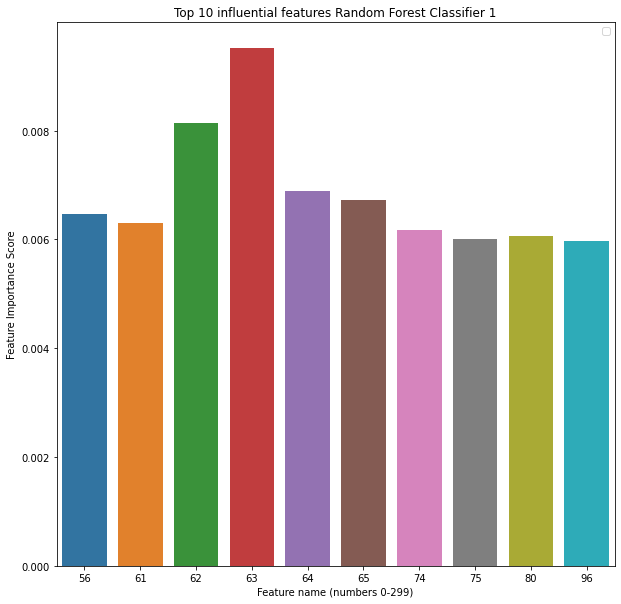

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Best Params ADBC: {'learning_rate': 0.001, 'n_estimators': 2000}
Weighted F1 score ADBC: 0.46358468588151486
Accuracy ADBC: 0.5055555555555555
Confusion matrix ADBC:
[[13  3 17  2]
 [ 1 12 19  6]
 [ 2  2 63  6]
 [ 1  3 27  3]]
Classification Report ADBC:
              precision    recall  f1-score   support

           0       0.76      0.37      0.50        35
           1       0.60      0.32      0.41        38
           2       0.50      0.86      0.63        73
           3       0.18      0.09      0.12        34

    accuracy                           0.51       180
   macro avg       0.51      0.41      0.42       180
weighted avg       0.51      0.51      0.46       180

Top 10 most influential feature column names:
Int64Index([63, 61, 78, 80, 64, 97, 60, 26, 65, 62], dtype='int64')
Feature values:
63    0.010192
61    0.007645
78    0.007464
80    0.007191
64    0.006873
97    0.006648
60    0.006463
26    0.006382
65    0.006299
62    0.006292
dtype: float64


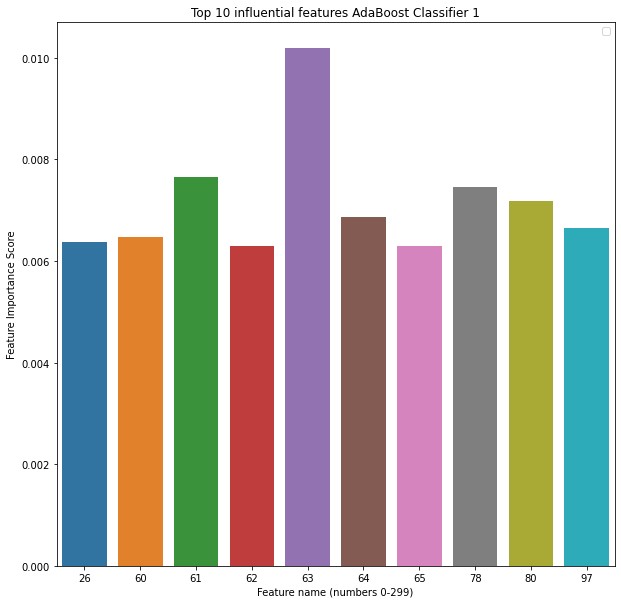

SVM is calculating....


c:\Users\h\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
450 fits failed out of a total of 1050.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
450 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\h\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\h\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_rfe.py", line 222, in fit
    return self._fit(X, y, **fit_params)
  File "c:\Users\h\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\fe

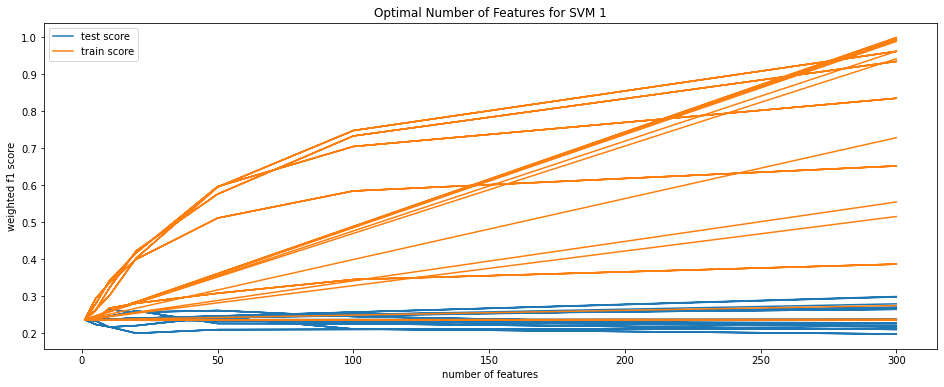

Top 10 most influential feature column names:
[262 144 158 260  84 182 258 252 254 256]
Feature values:
[0.00777778 0.00888889 0.00888889 0.00888889 0.00888889 0.01
 0.01       0.01111111 0.01111111 0.01111111]


<Figure size 720x1440 with 0 Axes>

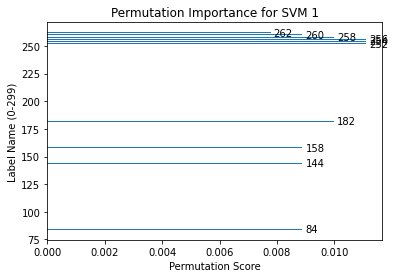

Best Params SVM: {'estimator__C': 10, 'estimator__gamma': 1, 'estimator__kernel': 'rbf', 'n_features_to_select': 300}
Weighted F1 score SVM: 0.33932854779628974
Accuracy SVM: 0.4222222222222222
Confusion matrix SVM:
[[ 3  4 27  1]
 [ 1  6 25  6]
 [ 0  2 64  7]
 [ 1  2 28  3]]
Classification Report SVM:
              precision    recall  f1-score   support

           0       0.60      0.09      0.15        35
           1       0.43      0.16      0.23        38
           2       0.44      0.88      0.59        73
           3       0.18      0.09      0.12        34

    accuracy                           0.42       180
   macro avg       0.41      0.30      0.27       180
weighted avg       0.42      0.42      0.34       180



c:\Users\h\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\h\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\h\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Best Params GBC: {'learning_rate': 0.001}
Weighted F1 score GBC: 0.23403601229688187
Accuracy GBC: 0.40555555555555556
Confusion matrix GBC:
[[ 0  0 35  0]
 [ 0  0 38  0]
 [ 0  0 73  0]
 [ 0  0 34  0]]
Classification Report GBC:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        35
           1       0.00      0.00      0.00        38
           2       0.41      1.00      0.58        73
           3       0.00      0.00      0.00        34

    accuracy                           0.41       180
   macro avg       0.10      0.25      0.14       180
weighted avg       0.16      0.41      0.23       180

Top 10 most influential feature column names:
Int64Index([63, 238, 81, 286, 169, 194, 259, 162, 25, 62], dtype='int64')
Feature values:
63     0.104237
238    0.077812
81     0.061766
286    0.061086
169    0.044439
194    0.043821
259    0.039506
162    0.039079
25     0.037587
62     0.036344
dtype: float64


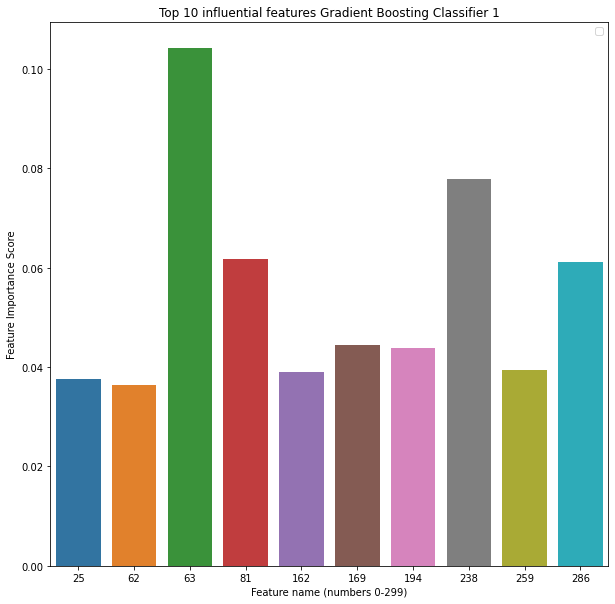


Early stopping occurred at epoch 360 with best_epoch = 60 and best_valid_f1w = 0.40233
Best weights from best epoch are automatically used!
Weighted F1 score Tabnet: 0.39284507052517287

Accuracy Tabnet: 0.42777777777777776

Confusion matrix Tabnet:
[[10  9 15  1]
 [ 3  7 22  6]
 [ 2  8 55  8]
 [ 9  5 15  5]]

Classification Report Tabnet:
              precision    recall  f1-score   support

           0       0.42      0.29      0.34        35
           1       0.24      0.18      0.21        38
           2       0.51      0.75      0.61        73
           3       0.25      0.15      0.19        34

    accuracy                           0.43       180
   macro avg       0.36      0.34      0.34       180
weighted avg       0.39      0.43      0.39       180



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Top 10 most influential feature column names:
Int64Index([69, 268, 18, 32, 293, 147, 38, 153, 243, 136], dtype='int64')
Feature values:
69     0.065510
268    0.052605
18     0.049088
32     0.045363
293    0.040136
147    0.038016
38     0.031582
153    0.031106
243    0.030498
136    0.029045
dtype: float64


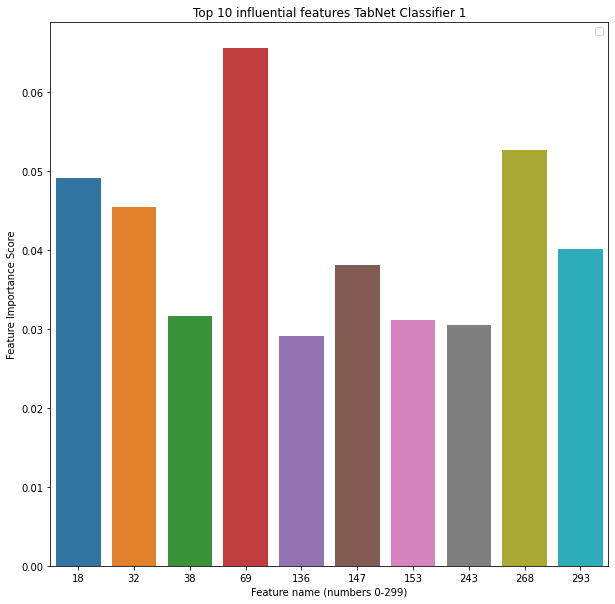

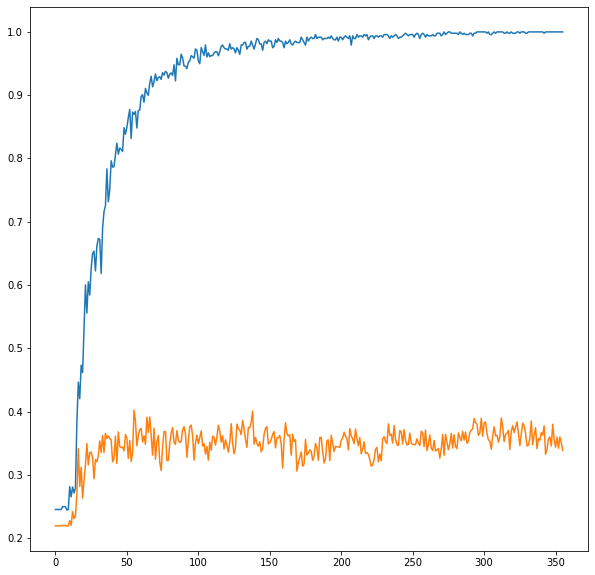

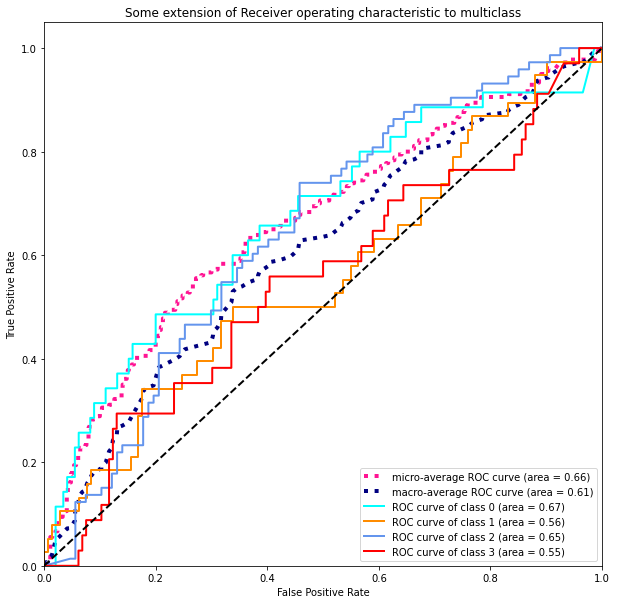

Fold: # 2


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Best Params RFC: {'max_depth': 80, 'max_features': 'sqrt'}
Weighted F1 score RFC: 0.48668952654944536
Accuracy RFC: 0.5277777777777778
Confusion matrix RFC:
[[13  7 14  1]
 [ 3 18 13  4]
 [ 3  5 61  4]
 [ 3  8 20  3]]
Classification Report RFC:
              precision    recall  f1-score   support

           0       0.59      0.37      0.46        35
           1       0.47      0.47      0.47        38
           2       0.56      0.84      0.67        73
           3       0.25      0.09      0.13        34

    accuracy                           0.53       180
   macro avg       0.47      0.44      0.43       180
weighted avg       0.49      0.53      0.49       180

Top 10 most influential feature column names:
Int64Index([80, 64, 51, 49, 56, 65, 193, 78, 157, 160], dtype='int64')
Feature values:
80     0.007960
64     0.007893
51     0.007725
49     0.007192
56     0.007110
65     0.006723
193    0.006555
78     0.006531
157    0.006411
160    0.006406
dtype: float64


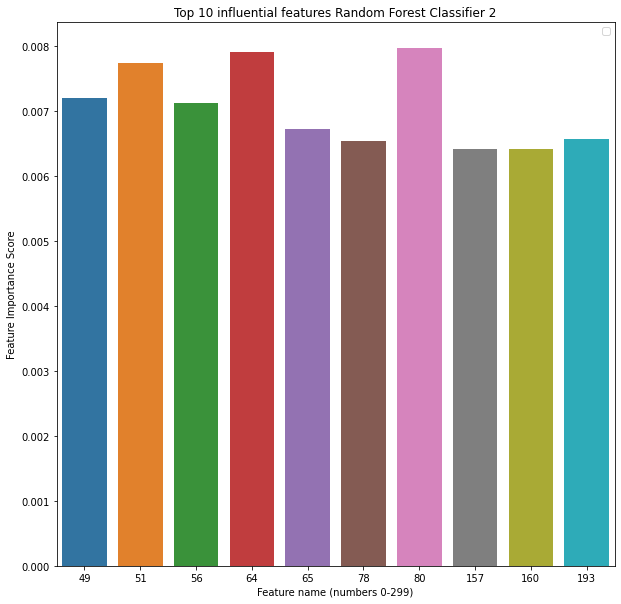

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Best Params ADBC: {'learning_rate': 0.01, 'n_estimators': 20}
Weighted F1 score ADBC: 0.504855726814722
Accuracy ADBC: 0.5388888888888889
Confusion matrix ADBC:
[[11  6 17  1]
 [ 5 17 14  2]
 [ 3  5 62  3]
 [ 4  8 15  7]]
Classification Report ADBC:
              precision    recall  f1-score   support

           0       0.48      0.31      0.38        35
           1       0.47      0.45      0.46        38
           2       0.57      0.85      0.69        73
           3       0.54      0.21      0.30        34

    accuracy                           0.54       180
   macro avg       0.52      0.45      0.46       180
weighted avg       0.53      0.54      0.50       180

Top 10 most influential feature column names:
Int64Index([63, 81, 60, 64, 79, 75, 80, 49, 62, 61], dtype='int64')
Feature values:
63    0.008016
81    0.007907
60    0.007885
64    0.007616
79    0.007386
75    0.007231
80    0.007039
49    0.007020
62    0.007012
61    0.006941
dtype: float64


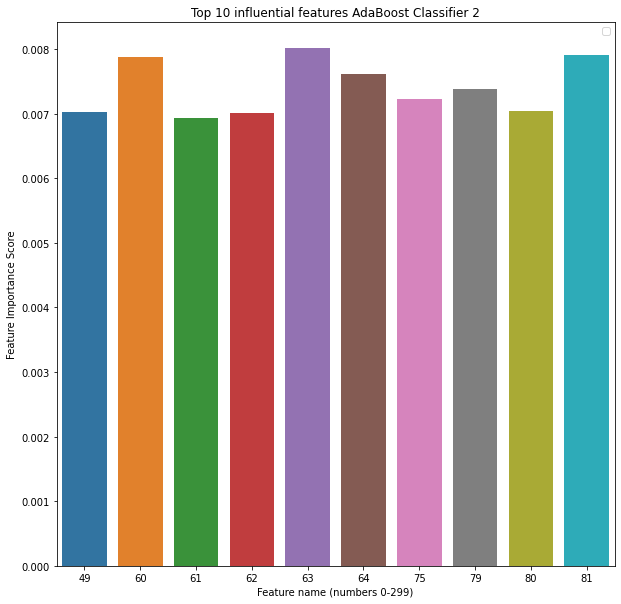

SVM is calculating....


c:\Users\h\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
450 fits failed out of a total of 1050.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
450 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\h\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\h\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_rfe.py", line 222, in fit
    return self._fit(X, y, **fit_params)
  File "c:\Users\h\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\fe

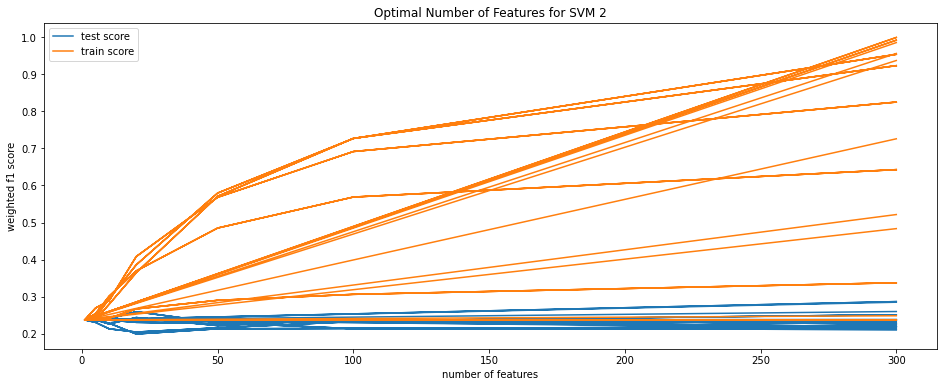

Top 10 most influential feature column names:
[252 194 271 196 289 295 278 291 297 299]
Feature values:
[0.00666667 0.00666667 0.00666667 0.00777778 0.00777778 0.00888889
 0.01       0.01       0.01222222 0.01333333]


<Figure size 720x1440 with 0 Axes>

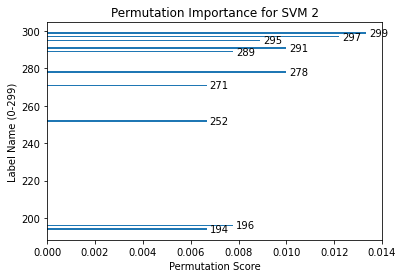

Best Params SVM: {'estimator__C': 50, 'estimator__gamma': 1, 'estimator__kernel': 'rbf', 'n_features_to_select': 300}
Weighted F1 score SVM: 0.40135529512514906
Accuracy SVM: 0.4666666666666667
Confusion matrix SVM:
[[ 5  3 27  0]
 [ 1 11 24  2]
 [ 1  3 64  5]
 [ 2  4 24  4]]
Classification Report SVM:
              precision    recall  f1-score   support

           0       0.56      0.14      0.23        35
           1       0.52      0.29      0.37        38
           2       0.46      0.88      0.60        73
           3       0.36      0.12      0.18        34

    accuracy                           0.47       180
   macro avg       0.48      0.36      0.35       180
weighted avg       0.47      0.47      0.40       180



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Best Params GBC: {'learning_rate': 0.01}
Weighted F1 score GBC: 0.3672475616302056
Accuracy GBC: 0.45555555555555555
Confusion matrix GBC:
[[ 6  1 27  1]
 [ 1  6 29  2]
 [ 3  0 68  2]
 [ 3  1 28  2]]
Classification Report GBC:
              precision    recall  f1-score   support

           0       0.46      0.17      0.25        35
           1       0.75      0.16      0.26        38
           2       0.45      0.93      0.60        73
           3       0.29      0.06      0.10        34

    accuracy                           0.46       180
   macro avg       0.49      0.33      0.30       180
weighted avg       0.48      0.46      0.37       180

Top 10 most influential feature column names:
Int64Index([64, 63, 193, 51, 79, 199, 272, 224, 213, 30], dtype='int64')
Feature values:
64     0.040645
63     0.032650
193    0.030991
51     0.025859
79     0.024443
199    0.022947
272    0.022139
224    0.020972
213    0.020415
30     0.019833
dtype: float64


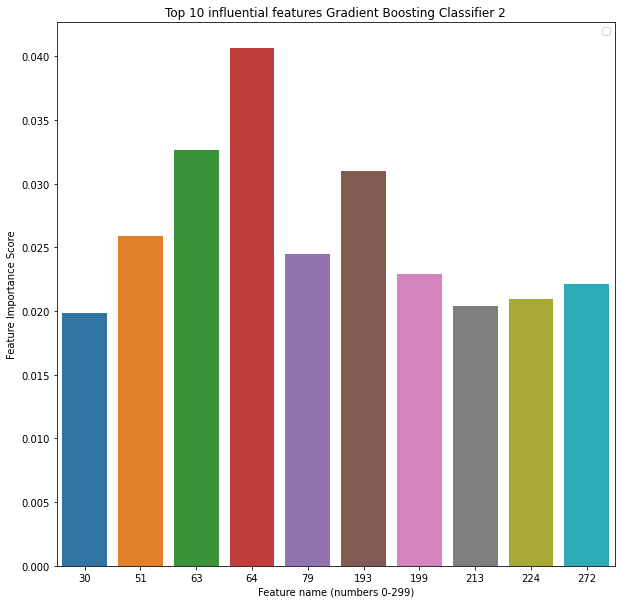


Early stopping occurred at epoch 798 with best_epoch = 498 and best_valid_f1w = 0.39165
Best weights from best epoch are automatically used!
Weighted F1 score Tabnet: 0.3736815442384231

Accuracy Tabnet: 0.39444444444444443

Confusion matrix Tabnet:
[[ 8  8 15  4]
 [ 7 13 12  6]
 [ 7 13 47  6]
 [ 6 11 14  3]]

Classification Report Tabnet:
              precision    recall  f1-score   support

           0       0.29      0.23      0.25        35
           1       0.29      0.34      0.31        38
           2       0.53      0.64      0.58        73
           3       0.16      0.09      0.11        34

    accuracy                           0.39       180
   macro avg       0.32      0.33      0.32       180
weighted avg       0.36      0.39      0.37       180



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Top 10 most influential feature column names:
Int64Index([145, 281, 298, 108, 159, 286, 48, 216, 186, 226], dtype='int64')
Feature values:
145    0.069650
281    0.056536
298    0.044336
108    0.044166
159    0.040593
286    0.035462
48     0.033488
216    0.033235
186    0.028080
226    0.027775
dtype: float64


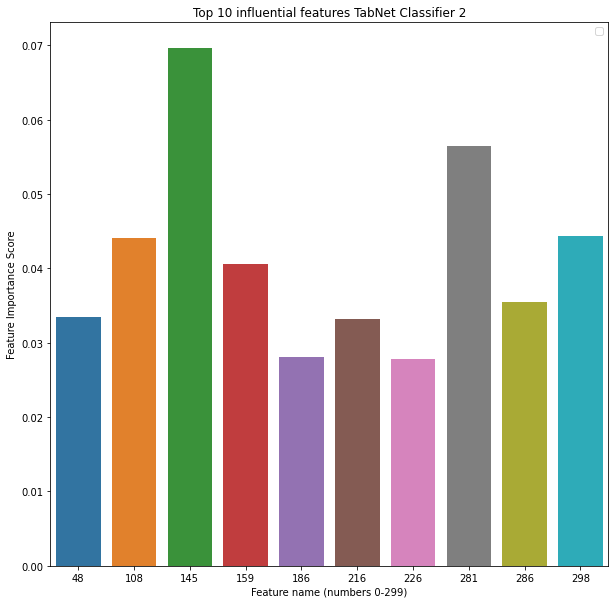

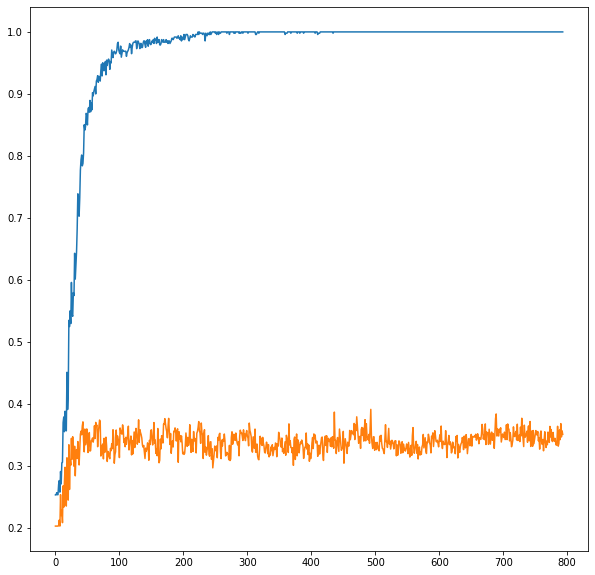

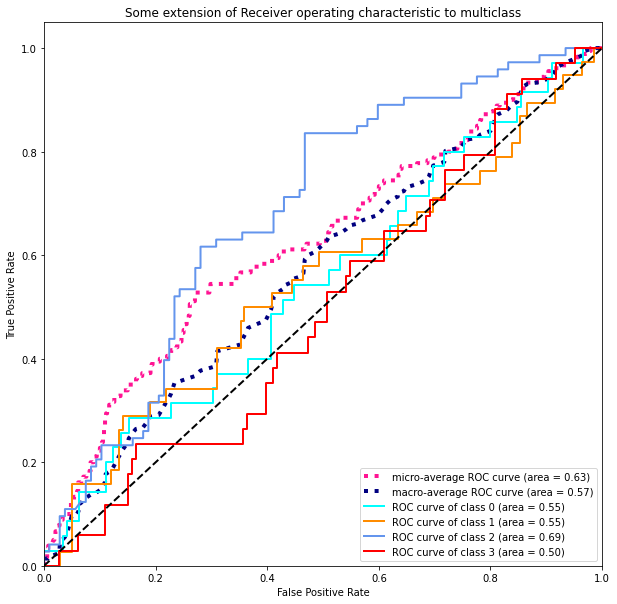

Fold: # 3


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Best Params RFC: {'max_depth': 10, 'max_features': 'auto'}
Weighted F1 score RFC: 0.4831136710846856
Accuracy RFC: 0.5166666666666667
Confusion matrix RFC:
[[11  7 13  3]
 [ 2 14 15  7]
 [ 4  4 62  4]
 [ 1  6 21  6]]
Classification Report RFC:
              precision    recall  f1-score   support

           0       0.61      0.32      0.42        34
           1       0.45      0.37      0.41        38
           2       0.56      0.84      0.67        74
           3       0.30      0.18      0.22        34

    accuracy                           0.52       180
   macro avg       0.48      0.43      0.43       180
weighted avg       0.50      0.52      0.48       180

Top 10 most influential feature column names:
Int64Index([60, 64, 80, 78, 61, 62, 56, 63, 65, 33], dtype='int64')
Feature values:
60    0.010755
64    0.009735
80    0.009534
78    0.008998
61    0.008445
62    0.008024
56    0.007458
63    0.007333
65    0.007270
33    0.007154
dtype: float64


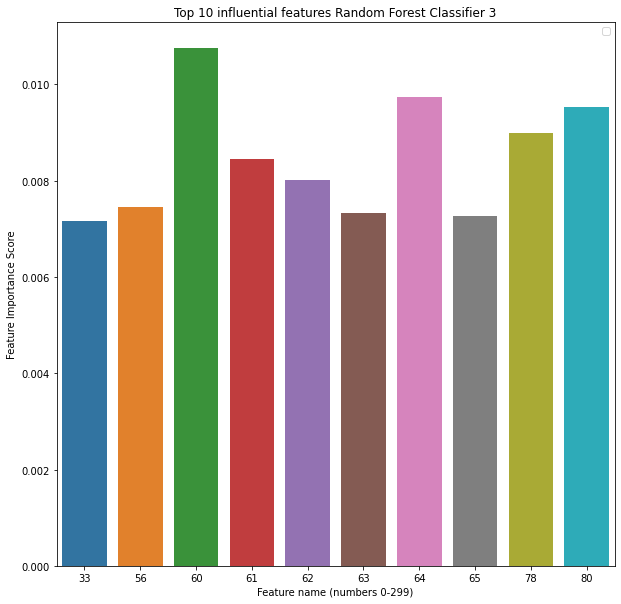

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Best Params ADBC: {'learning_rate': 1, 'n_estimators': 100}
Weighted F1 score ADBC: 0.5072505503755503
Accuracy ADBC: 0.5388888888888889
Confusion matrix ADBC:
[[13  6 12  3]
 [ 3 13 19  3]
 [ 4  3 63  4]
 [ 1  4 21  8]]
Classification Report ADBC:
              precision    recall  f1-score   support

           0       0.62      0.38      0.47        34
           1       0.50      0.34      0.41        38
           2       0.55      0.85      0.67        74
           3       0.44      0.24      0.31        34

    accuracy                           0.54       180
   macro avg       0.53      0.45      0.46       180
weighted avg       0.53      0.54      0.51       180

Top 10 most influential feature column names:
Int64Index([80, 60, 61, 78, 62, 63, 64, 51, 39, 56], dtype='int64')
Feature values:
80    0.009431
60    0.007846
61    0.007346
78    0.007175
62    0.006890
63    0.006811
64    0.006756
51    0.006752
39    0.006345
56    0.006340
dtype: float64


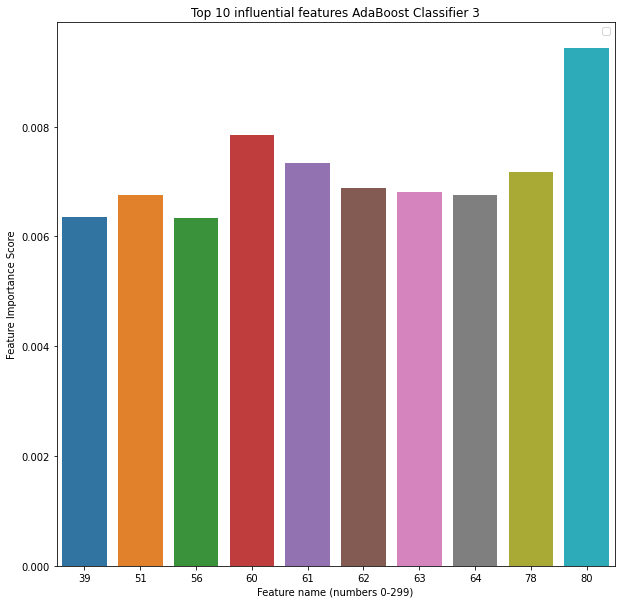

SVM is calculating....


c:\Users\h\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
450 fits failed out of a total of 1050.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
450 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\h\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\h\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_rfe.py", line 222, in fit
    return self._fit(X, y, **fit_params)
  File "c:\Users\h\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\fe

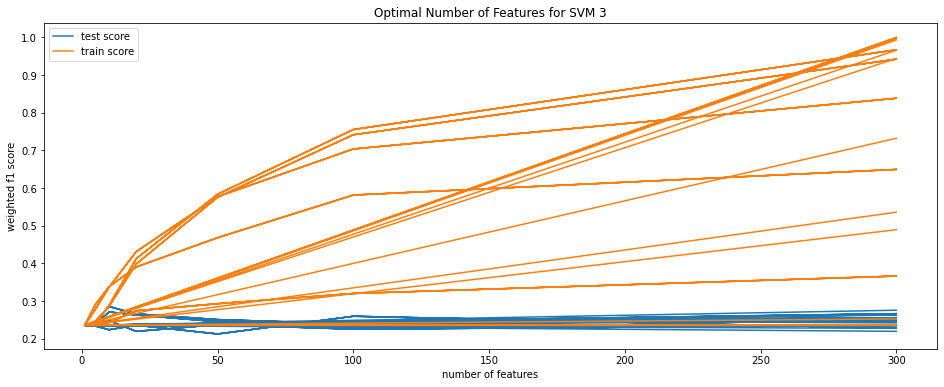

[[-2.12471236e+00  2.15182425e+00  1.92736650e+00  6.40318263e-03
  -1.71903728e+00  1.58192042e+00 -1.09722200e+00 -2.30645808e+00
   1.17077292e+00 -1.18668983e-01]
 [-5.14152296e-01  1.26364093e-01  6.56762758e-01 -1.19386057e-01
  -1.07932850e+00  1.76001423e+00 -2.04560659e+00 -3.22445328e-01
   8.56512133e-01 -1.48306477e-01]
 [-9.03254055e-01  1.55089493e+00  7.93252009e-01  2.68960180e+00
  -1.44478237e+00 -9.14759922e-01 -1.18279808e+00  5.14172629e-01
   1.19562300e+00 -2.04570446e+00]
 [-9.04698044e-05 -9.71614867e-04  9.98072537e-04  1.20012377e-04
  -1.41349347e-04 -1.00320426e-04 -7.02821336e-04 -3.43268527e-05
  -5.69973987e-05 -3.24723808e-04]
 [ 4.03229272e-01  3.76926815e-02 -3.54436668e-01  2.70242562e+00
   1.78573596e-01 -1.37911653e+00 -3.24647263e-01  2.95563846e+00
   4.14415310e-01 -3.03366979e+00]
 [-5.71610663e-03  2.11709145e-01 -1.97789056e-01  3.71041770e-01
   4.85257678e-03 -4.51900344e-01  1.42227765e-01  5.38930883e-02
   3.83549271e-02  8.86572103e-04

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Best Params GBC: {'learning_rate': 0.01}
Weighted F1 score GBC: 0.37473283560240084
Accuracy GBC: 0.46111111111111114
Confusion matrix GBC:
[[ 5  5 24  0]
 [ 4  4 27  3]
 [ 2  1 69  2]
 [ 1  0 28  5]]
Classification Report GBC:
              precision    recall  f1-score   support

           0       0.42      0.15      0.22        34
           1       0.40      0.11      0.17        38
           2       0.47      0.93      0.62        74
           3       0.50      0.15      0.23        34

    accuracy                           0.46       180
   macro avg       0.45      0.33      0.31       180
weighted avg       0.45      0.46      0.37       180

Top 10 most influential feature column names:
Int64Index([62, 79, 60, 204, 49, 66, 30, 238, 63, 75], dtype='int64')
Feature values:
62     0.047587
79     0.046560
60     0.035089
204    0.028382
49     0.023680
66     0.023550
30     0.023330
238    0.021835
63     0.021684
75     0.020082
dtype: float64


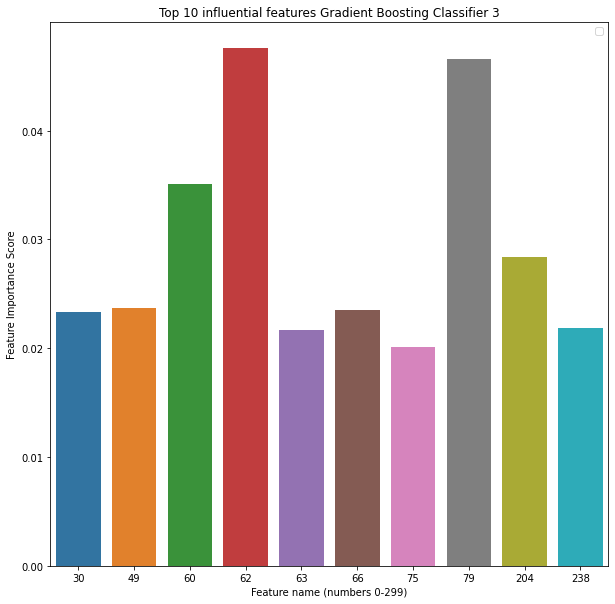


Early stopping occurred at epoch 721 with best_epoch = 421 and best_valid_f1w = 0.44518
Best weights from best epoch are automatically used!
Weighted F1 score Tabnet: 0.3552905109002287

Accuracy Tabnet: 0.35555555555555557

Confusion matrix Tabnet:
[[13  8  8  5]
 [ 7  9 13  9]
 [ 9 16 37 12]
 [ 6  8 15  5]]

Classification Report Tabnet:
              precision    recall  f1-score   support

           0       0.37      0.38      0.38        34
           1       0.22      0.24      0.23        38
           2       0.51      0.50      0.50        74
           3       0.16      0.15      0.15        34

    accuracy                           0.36       180
   macro avg       0.31      0.32      0.32       180
weighted avg       0.36      0.36      0.36       180



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Top 10 most influential feature column names:
Int64Index([109, 32, 219, 216, 273, 205, 221, 71, 25, 277], dtype='int64')
Feature values:
109    0.069580
32     0.067610
219    0.045387
216    0.042824
273    0.032221
205    0.032040
221    0.031122
71     0.030484
25     0.029707
277    0.026540
dtype: float64


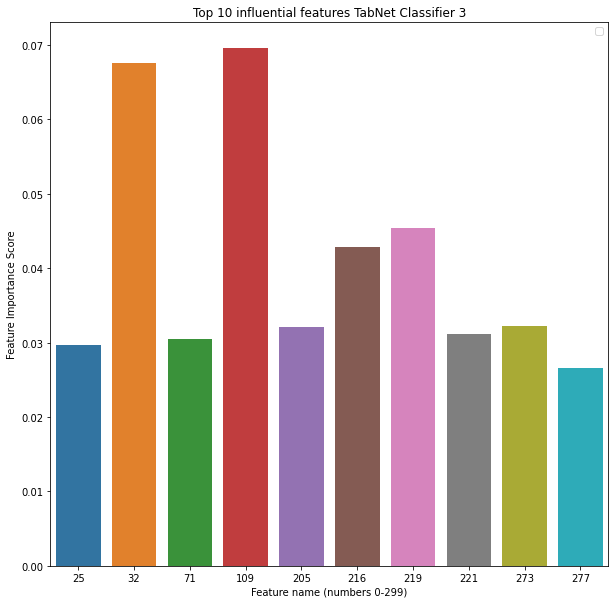

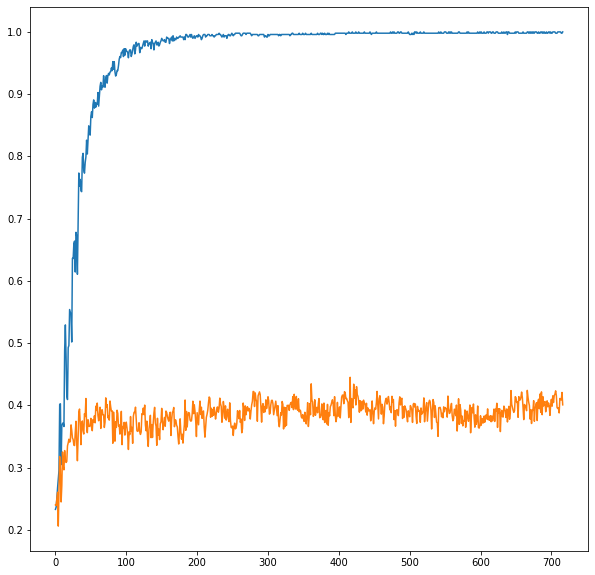

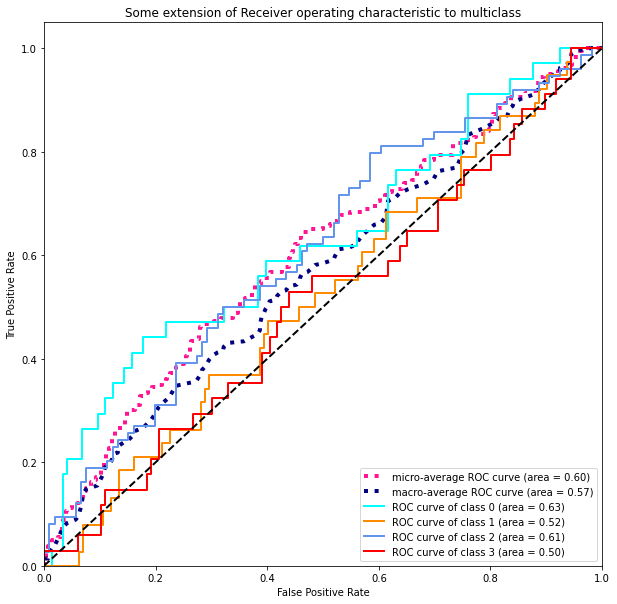

Fold: # 4


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Best Params RFC: {'max_depth': 150, 'max_features': 'auto'}
Weighted F1 score RFC: 0.4480316704789692
Accuracy RFC: 0.4888888888888889
Confusion matrix RFC:
[[12  5 15  2]
 [ 3  9 25  2]
 [ 5  4 61  4]
 [ 1  5 21  6]]
Classification Report RFC:
              precision    recall  f1-score   support

           0       0.57      0.35      0.44        34
           1       0.39      0.23      0.29        39
           2       0.50      0.82      0.62        74
           3       0.43      0.18      0.26        33

    accuracy                           0.49       180
   macro avg       0.47      0.40      0.40       180
weighted avg       0.48      0.49      0.45       180

Top 10 most influential feature column names:
Int64Index([64, 62, 61, 82, 63, 80, 58, 51, 75, 78], dtype='int64')
Feature values:
64    0.009349
62    0.007650
61    0.007459
82    0.007220
63    0.006825
80    0.006777
58    0.006598
51    0.006452
75    0.006349
78    0.006264
dtype: float64


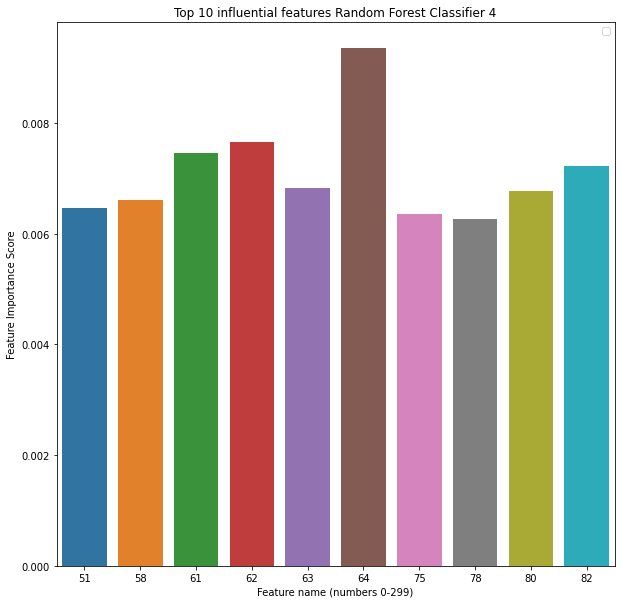

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Best Params ADBC: {'learning_rate': 1, 'n_estimators': 1000}
Weighted F1 score ADBC: 0.5024466734005635
Accuracy ADBC: 0.5388888888888889
Confusion matrix ADBC:
[[16  3 13  2]
 [ 3 13 21  2]
 [ 3  3 63  5]
 [ 2  6 20  5]]
Classification Report ADBC:
              precision    recall  f1-score   support

           0       0.67      0.47      0.55        34
           1       0.52      0.33      0.41        39
           2       0.54      0.85      0.66        74
           3       0.36      0.15      0.21        33

    accuracy                           0.54       180
   macro avg       0.52      0.45      0.46       180
weighted avg       0.53      0.54      0.50       180

Top 10 most influential feature column names:
Int64Index([62, 64, 78, 61, 73, 80, 82, 49, 63, 60], dtype='int64')
Feature values:
62    0.008876
64    0.008735
78    0.007770
61    0.007252
73    0.007115
80    0.006840
82    0.006724
49    0.006424
63    0.006347
60    0.006207
dtype: float64


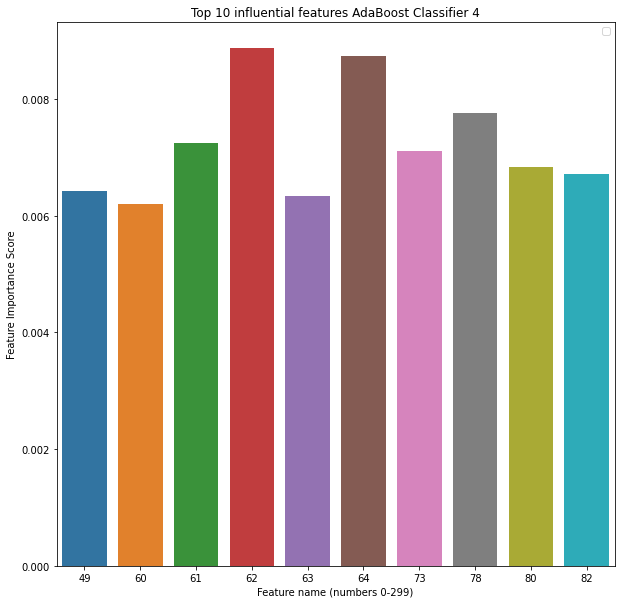

SVM is calculating....


c:\Users\h\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
450 fits failed out of a total of 1050.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
450 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\h\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\h\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_rfe.py", line 222, in fit
    return self._fit(X, y, **fit_params)
  File "c:\Users\h\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\fe

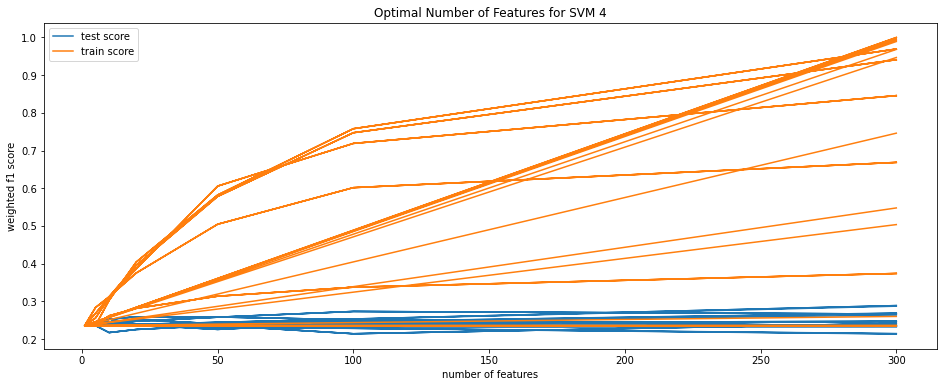

Top 10 most influential feature column names:
[280 238 279  67 295 269 237 239 287 285]
Feature values:
[0.00555556 0.00555556 0.00777778 0.00777778 0.00777778 0.00777778
 0.00777778 0.00888889 0.01111111 0.01555556]


<Figure size 720x1440 with 0 Axes>

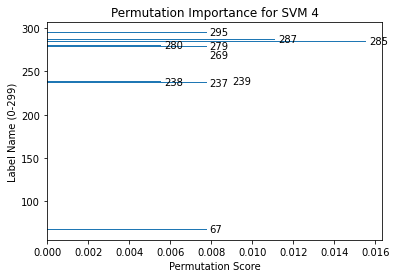

Best Params SVM: {'estimator__C': 50, 'estimator__gamma': 1, 'estimator__kernel': 'rbf', 'n_features_to_select': 300}
Weighted F1 score SVM: 0.3789062399588715
Accuracy SVM: 0.46111111111111114
Confusion matrix SVM:
[[ 4  2 25  3]
 [ 1  7 30  1]
 [ 1  4 68  1]
 [ 0  5 24  4]]
Classification Report SVM:
              precision    recall  f1-score   support

           0       0.67      0.12      0.20        34
           1       0.39      0.18      0.25        39
           2       0.46      0.92      0.62        74
           3       0.44      0.12      0.19        33

    accuracy                           0.46       180
   macro avg       0.49      0.33      0.31       180
weighted avg       0.48      0.46      0.38       180



c:\Users\h\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\h\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\h\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Best Params GBC: {'learning_rate': 0.001}
Weighted F1 score GBC: 0.23954505686789157
Accuracy GBC: 0.4111111111111111
Confusion matrix GBC:
[[ 0  0 34  0]
 [ 0  0 39  0]
 [ 0  0 74  0]
 [ 0  0 33  0]]
Classification Report GBC:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        34
           1       0.00      0.00      0.00        39
           2       0.41      1.00      0.58        74
           3       0.00      0.00      0.00        33

    accuracy                           0.41       180
   macro avg       0.10      0.25      0.15       180
weighted avg       0.17      0.41      0.24       180

Top 10 most influential feature column names:
Int64Index([51, 238, 62, 215, 30, 156, 99, 60, 50, 181], dtype='int64')
Feature values:
51     0.076955
238    0.064127
62     0.061921
215    0.056450
30     0.048922
156    0.048201
99     0.042410
60     0.039685
50     0.029600
181    0.026527
dtype: float64


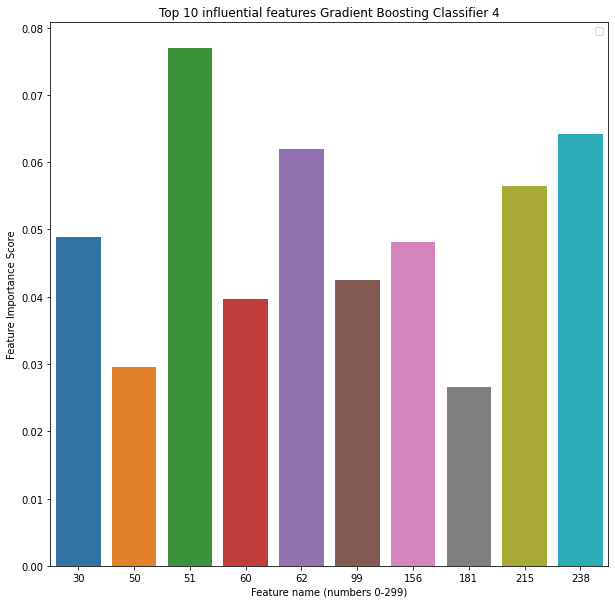


Early stopping occurred at epoch 456 with best_epoch = 156 and best_valid_f1w = 0.38912
Best weights from best epoch are automatically used!
Weighted F1 score Tabnet: 0.4265721796071436

Accuracy Tabnet: 0.43333333333333335

Confusion matrix Tabnet:
[[11  5 12  6]
 [ 4 14 15  6]
 [ 5 13 46 10]
 [ 2 12 12  7]]

Classification Report Tabnet:
              precision    recall  f1-score   support

           0       0.50      0.32      0.39        34
           1       0.32      0.36      0.34        39
           2       0.54      0.62      0.58        74
           3       0.24      0.21      0.23        33

    accuracy                           0.43       180
   macro avg       0.40      0.38      0.38       180
weighted avg       0.43      0.43      0.43       180



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Top 10 most influential feature column names:
Int64Index([162, 255, 22, 152, 71, 167, 141, 190, 127, 208], dtype='int64')
Feature values:
162    0.078763
255    0.070715
22     0.045815
152    0.038241
71     0.031727
167    0.031237
141    0.029134
190    0.027850
127    0.026476
208    0.025937
dtype: float64


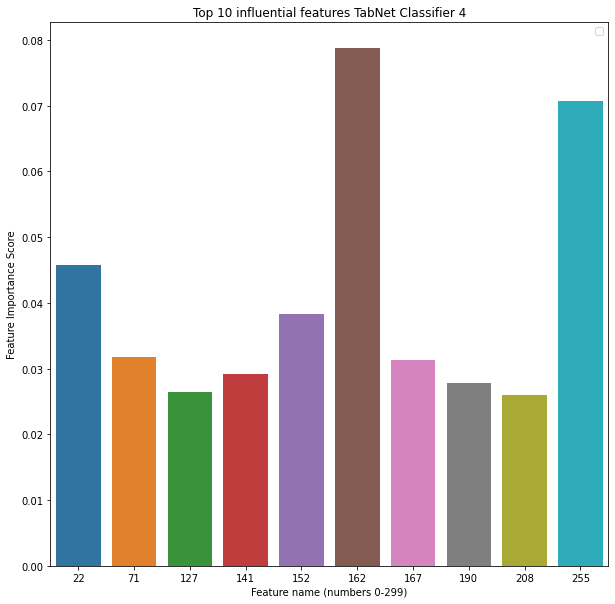

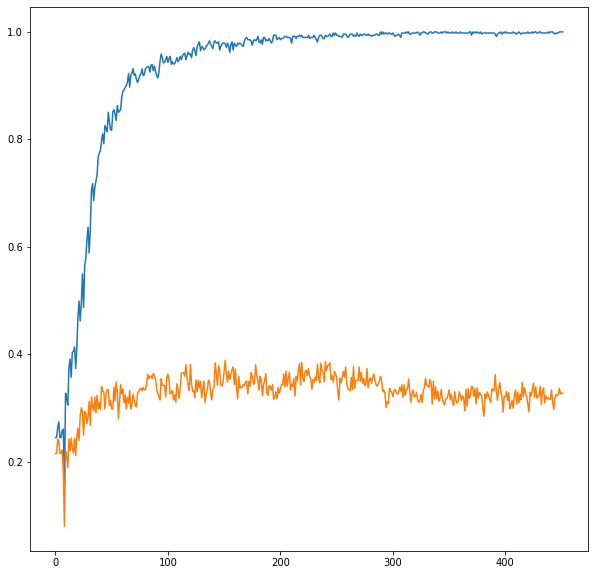

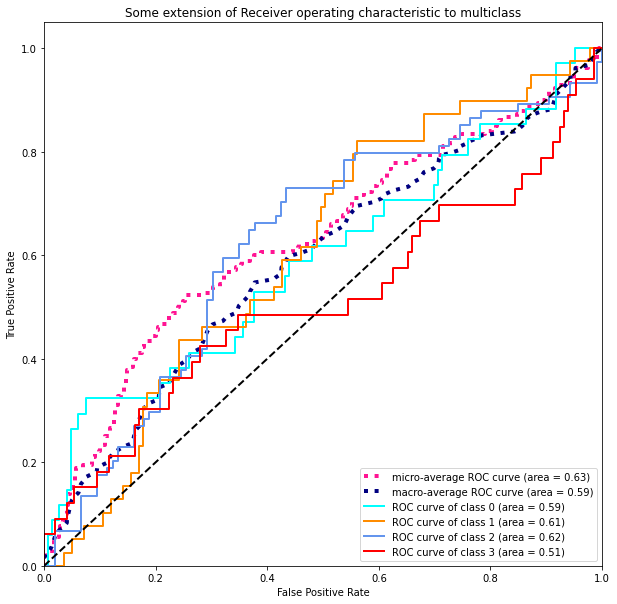

Fold: # 5


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Best Params RFC: {'max_depth': 100, 'max_features': 'sqrt'}
Weighted F1 score RFC: 0.5005992740243888
Accuracy RFC: 0.5333333333333333
Confusion matrix RFC:
[[13  5 13  3]
 [ 9 13 16  1]
 [ 7  3 62  1]
 [ 0  3 23  8]]
Classification Report RFC:
              precision    recall  f1-score   support

           0       0.45      0.38      0.41        34
           1       0.54      0.33      0.41        39
           2       0.54      0.85      0.66        73
           3       0.62      0.24      0.34        34

    accuracy                           0.53       180
   macro avg       0.54      0.45      0.46       180
weighted avg       0.54      0.53      0.50       180

Top 10 most influential feature column names:
Int64Index([62, 64, 60, 61, 52, 58, 78, 72, 156, 80], dtype='int64')
Feature values:
62     0.012995
64     0.009157
60     0.008874
61     0.008470
52     0.007642
58     0.007375
78     0.007247
72     0.006777
156    0.006749
80     0.006506
dtype: float64


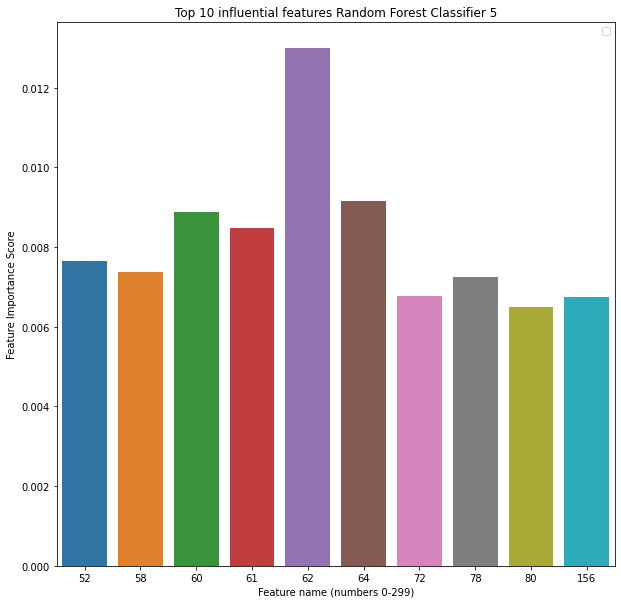

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Best Params ADBC: {'learning_rate': 0.001, 'n_estimators': 20}
Weighted F1 score ADBC: 0.49207550426113944
Accuracy ADBC: 0.5333333333333333
Confusion matrix ADBC:
[[14  6 11  3]
 [ 8 12 17  2]
 [ 6  2 64  1]
 [ 1  5 22  6]]
Classification Report ADBC:
              precision    recall  f1-score   support

           0       0.48      0.41      0.44        34
           1       0.48      0.31      0.38        39
           2       0.56      0.88      0.68        73
           3       0.50      0.18      0.26        34

    accuracy                           0.53       180
   macro avg       0.51      0.44      0.44       180
weighted avg       0.52      0.53      0.49       180

Top 10 most influential feature column names:
Int64Index([62, 60, 64, 50, 58, 63, 51, 45, 31, 61], dtype='int64')
Feature values:
62    0.011179
60    0.009270
64    0.009024
50    0.008450
58    0.007862
63    0.007473
51    0.007122
45    0.007022
31    0.006910
61    0.006905
dtype: float64


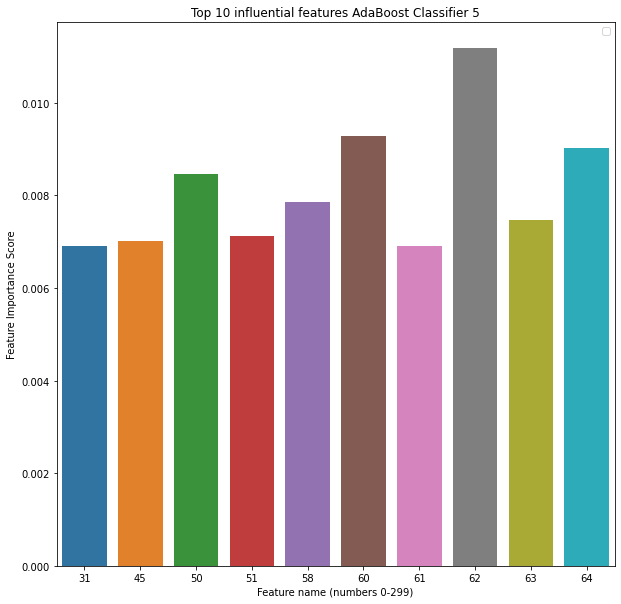

SVM is calculating....


c:\Users\h\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
450 fits failed out of a total of 1050.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
450 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\h\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\h\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_rfe.py", line 222, in fit
    return self._fit(X, y, **fit_params)
  File "c:\Users\h\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\fe

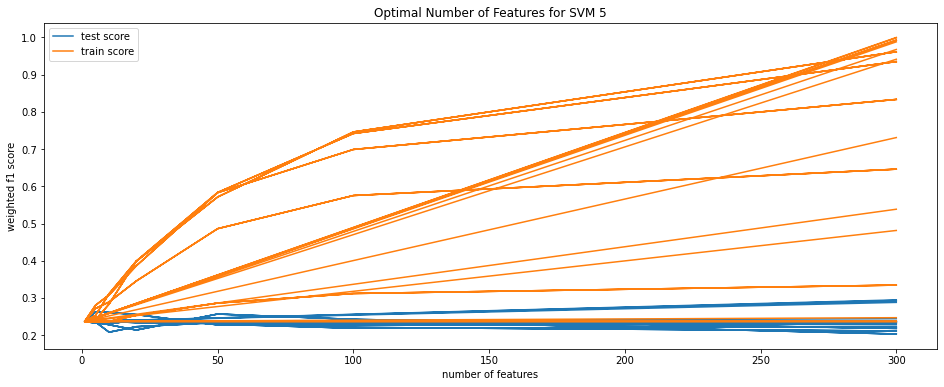

Top 10 most influential feature column names:
[252 129  45  67 279 149 254  69 287  71]
Feature values:
[0.00555556 0.00555556 0.00666667 0.00666667 0.00777778 0.00777778
 0.00888889 0.01       0.01111111 0.01222222]


<Figure size 720x1440 with 0 Axes>

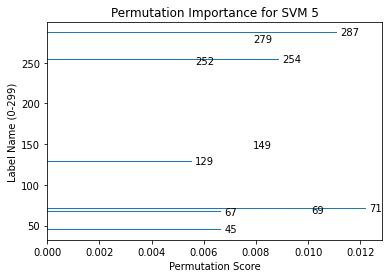

Best Params SVM: {'estimator__C': 100, 'estimator__gamma': 1, 'estimator__kernel': 'rbf', 'n_features_to_select': 300}
Weighted F1 score SVM: 0.3527010414219716
Accuracy SVM: 0.4444444444444444
Confusion matrix SVM:
[[ 3  1 27  3]
 [ 4  5 28  2]
 [ 3  2 68  0]
 [ 1  5 24  4]]
Classification Report SVM:
              precision    recall  f1-score   support

           0       0.27      0.09      0.13        34
           1       0.38      0.13      0.19        39
           2       0.46      0.93      0.62        73
           3       0.44      0.12      0.19        34

    accuracy                           0.44       180
   macro avg       0.39      0.32      0.28       180
weighted avg       0.41      0.44      0.35       180



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Best Params GBC: {'learning_rate': 0.01}
Weighted F1 score GBC: 0.34332039446817064
Accuracy GBC: 0.4388888888888889
Confusion matrix GBC:
[[ 9  2 20  3]
 [ 6  2 30  1]
 [ 5  1 66  1]
 [ 0  0 32  2]]
Classification Report GBC:
              precision    recall  f1-score   support

           0       0.45      0.26      0.33        34
           1       0.40      0.05      0.09        39
           2       0.45      0.90      0.60        73
           3       0.29      0.06      0.10        34

    accuracy                           0.44       180
   macro avg       0.40      0.32      0.28       180
weighted avg       0.41      0.44      0.34       180

Top 10 most influential feature column names:
Int64Index([62, 156, 64, 51, 75, 159, 238, 213, 61, 44], dtype='int64')
Feature values:
62     0.096570
156    0.048710
64     0.039651
51     0.032659
75     0.029178
159    0.027757
238    0.024679
213    0.022911
61     0.022788
44     0.021502
dtype: float64


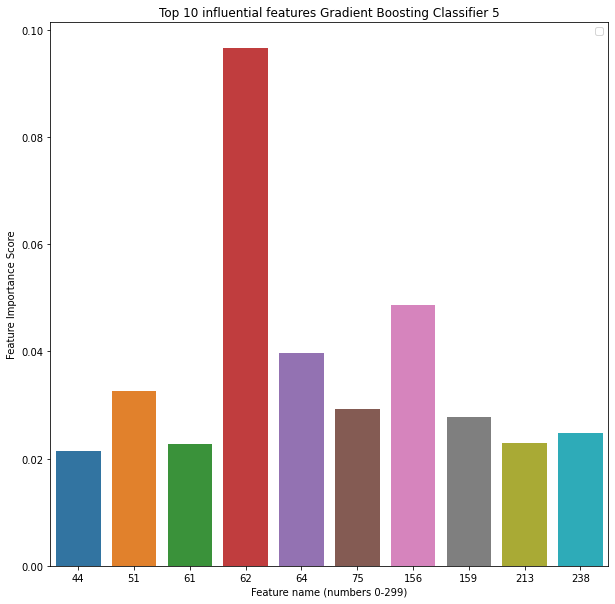


Early stopping occurred at epoch 654 with best_epoch = 354 and best_valid_f1w = 0.44473
Best weights from best epoch are automatically used!
Weighted F1 score Tabnet: 0.3837325686009897

Accuracy Tabnet: 0.3888888888888889

Confusion matrix Tabnet:
[[ 8  9  9  8]
 [12 10 10  7]
 [ 9 11 43 10]
 [ 2  6 17  9]]

Classification Report Tabnet:
              precision    recall  f1-score   support

           0       0.26      0.24      0.25        34
           1       0.28      0.26      0.27        39
           2       0.54      0.59      0.57        73
           3       0.26      0.26      0.26        34

    accuracy                           0.39       180
   macro avg       0.34      0.34      0.34       180
weighted avg       0.38      0.39      0.38       180



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Top 10 most influential feature column names:
Int64Index([297, 235, 126, 146, 299, 112, 14, 259, 30, 183], dtype='int64')
Feature values:
297    0.093779
235    0.045945
126    0.036426
146    0.034708
299    0.033985
112    0.033435
14     0.032879
259    0.029883
30     0.027533
183    0.027016
dtype: float64


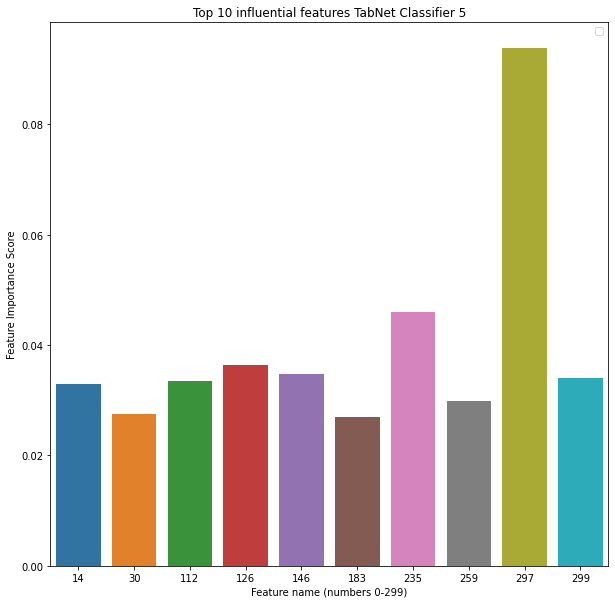

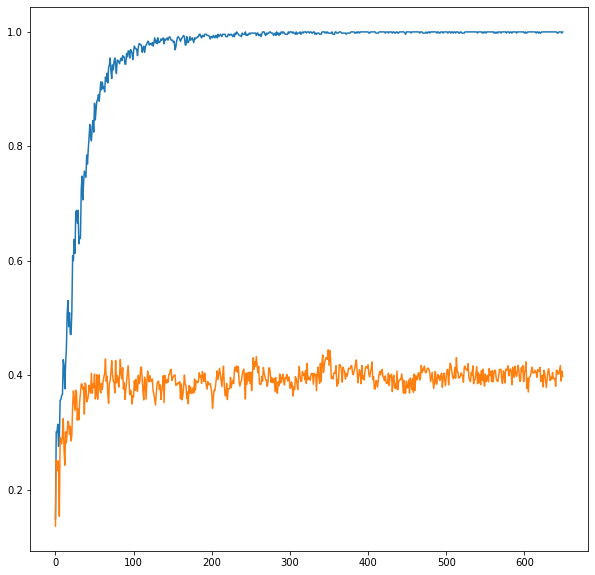

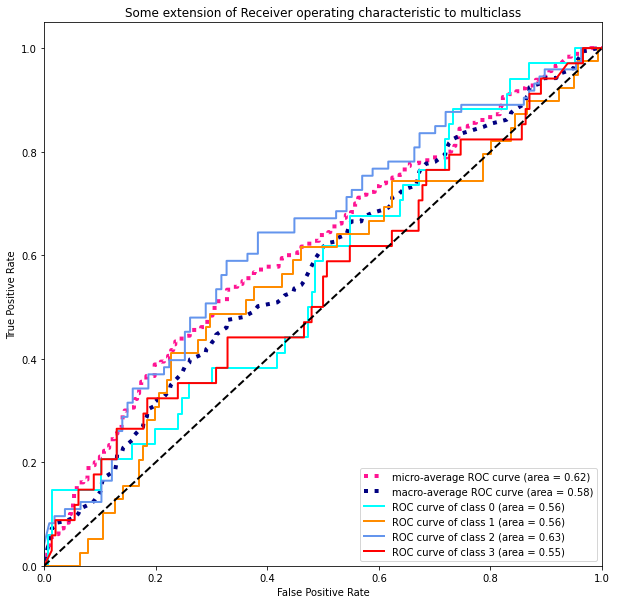

In [10]:
%matplotlib inline

X = z
features = pd.DataFrame(X)
feature_names = features.columns

labels = label_loader(labelspath)
y = labels

kf = StratifiedKFold(n_splits = 5, shuffle=True, random_state=420)          

fold = 1
f1_scores = []
roc_auc_scores = []
accuracy_scores = []
for train, test in kf.split(X, y):
    print('Fold: #', fold)
    y_train = y[train]
    X_train = X[train]
    y_test = y[test]
    X_test = X[test]

    #X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.33, random_state = 1)

    #RandomForestClassifier stats
    rfclf=RandomForestClassifier()
    modelname1 = "Random Forest Classifier "+str(fold)

    parameters1 = {
        'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, None],
        'max_features': ['auto', 'sqrt'],
        }


    clf = GridSearchCV(
        estimator=rfclf, 
        param_grid=parameters1,
        n_jobs=-1,
        scoring=['f1_weighted', 'accuracy'],
        refit='f1_weighted' 
    )

    clf.fit(X_train, y_train)

    y_pred1 = clf.predict(X_test)
    test_cm1 = confusion_matrix(y_test,y_pred1)
    test_report1 = classification_report(y_test,y_pred1)
    print('Best Params RFC:', clf.best_params_)
    print("Weighted F1 score RFC:",f1_score(y_test, y_pred1, average='weighted'))
    print("Accuracy RFC:",metrics.accuracy_score(y_test, y_pred1))
    print("Confusion matrix RFC:")
    print(test_cm1)
    print("Classification Report RFC:")
    print(test_report1)
    feature_imp1 = pd.Series(clf.best_estimator_.feature_importances_).sort_values(ascending=False)
    featureplot(feature_imp1, modelname1)

    #AdaboostClassifier stats
    adb = AdaBoostClassifier(base_estimator=clf.best_estimator_) #, n_estimators=300, learning_rate=1
    modelname2 = "AdaBoost Classifier "+str(fold)

    
    parameters2 = {
    'n_estimators':[1, 5, 10, 20, 50, 100, 500, 1000, 2000],
    'learning_rate':[0.001, 0.01, 0.1, 1]
    }

    adbc = GridSearchCV(
        estimator=adb, 
        param_grid=parameters2,
        n_jobs=-1,
        scoring=['f1_weighted', 'accuracy'],
        refit='f1_weighted' 
    )

    adbc.fit(X_train,y_train)

    y_pred2 = adbc.predict(X_test)
    test_cm2 = confusion_matrix(y_test,y_pred2)
    test_report2 = classification_report(y_test,y_pred2)
    print('Best Params ADBC:', adbc.best_params_)
    print("Weighted F1 score ADBC:",f1_score(y_test, y_pred2, average='weighted'))
    print("Accuracy ADBC:",metrics.accuracy_score(y_test, y_pred2))
    print("Confusion matrix ADBC:")
    print(test_cm2)
    print("Classification Report ADBC:")
    print(test_report2)
    feature_imp2 = pd.Series(adbc.best_estimator_.feature_importances_).sort_values(ascending=False)
    featureplot(feature_imp2, modelname2)

    #SVM Classifier stats
    svc = svm.SVC() 

    rfe = RFE(estimator=svc, step=1) #n_estimators = 10 for top 10 influential features

    parameters4 = {
        'estimator__kernel':['linear', 'rbf'],
        'estimator__C':[0.1, 1, 10, 50, 100],
        'estimator__gamma': [1, 0.1, 0.01],
        'n_features_to_select': [1, 5, 10, 20, 50, 100, 300]
        }
                   
    svcclf = GridSearchCV(
        estimator=rfe, 
        param_grid=parameters4,
        n_jobs=-1,
        scoring=['f1_weighted', 'accuracy'],
        refit='f1_weighted',
        return_train_score = True
    )
    #svcclf = svcclf.best_estimator_
    print("SVM is calculating....")
    svcclf.fit(X_train, y_train)
    #print(svcclf.cv_results_)


    #    print('Best Params:', svcclf.best_params_)
    #    print('Best Score:', svcclf.best_score_)
    #pd.Series(abs(svm.coef_[0]), index=features.columns).nlargest(10).plot(kind='barh')

    y_pred4 = svcclf.predict(X_test)
    test_cm4 = confusion_matrix(y_test,y_pred4)
    test_report4 = classification_report(y_test,y_pred4)
    if svcclf.best_params_['estimator__kernel'] == 'linear':
        svmfeatureplot(svcclf.cv_results_, fold)
        svmfeatureimportance(svcclf.best_estimator_.estimator_.coef_, feature_names)

    if svcclf.best_params_['estimator__kernel'] == 'rbf':
        svmfeatureplot(svcclf.cv_results_, fold)
        perm_importance = permutation_importance(svcclf.best_estimator_, X_test, y_test)
        svmrbfplot(perm_importance, feature_names, fold)

    #    print('Coefficients:', svcclf.best_estimator_.estimator__.coef_)
    
    print('Best Params SVM:', svcclf.best_params_)
    print("Weighted F1 score SVM:",f1_score(y_test, y_pred4, average='weighted'))   #Might give F1 score warning for not predicting all classes
    print("Accuracy SVM:",metrics.accuracy_score(y_test, y_pred4))
    print("Confusion matrix SVM:")
    print(test_cm4)
    print("Classification Report SVM:")
    print(test_report4)
    #Make feature importance graph
    #feature_imp4 = pd.Series(svcclf.feature_importances_).sort_values(ascending=False)
    #featureplot(feature_imp4)

    #GradientBoostingClassifier stats
    gradbc = GradientBoostingClassifier()
    modelname3 = "Gradient Boosting Classifier "+str(fold)

    parameters3 = {
            #'n_estimators':[1, 50, 100, 500],
            'learning_rate':[0.001, 0.01, 0.1, 1]
    }
                   
    gbc = GridSearchCV(
        estimator=gradbc, 
        param_grid=parameters3,
        n_jobs=-1,
        scoring=['f1_weighted', 'accuracy'],
        refit='f1_weighted' 
    )    

    gbc.fit(X_train, y_train)

    y_pred3 = gbc.predict(X_test)
    test_cm3 = confusion_matrix(y_test,y_pred3)
    test_report3 = classification_report(y_test,y_pred3)
    print('Best Params GBC:', gbc.best_params_)
    print("Weighted F1 score GBC:",f1_score(y_test, y_pred3, average='weighted'))
    print("Accuracy GBC:",metrics.accuracy_score(y_test, y_pred3))
    print("Confusion matrix GBC:")
    print(test_cm3)
    print("Classification Report GBC:")
    print(test_report3)
    #Make feature importance graph
    feature_imp3 = pd.Series(gbc.best_estimator_.feature_importances_).sort_values(ascending=False)
    featureplot(feature_imp3, modelname3)

    #Tabnet Classifier
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.33, random_state = 1)

    modelname4 = "TabNet Classifier "+str(fold)

    tabclf = TabNetClassifier(
        n_d=64, n_a=64, n_steps=1,
        gamma=1.2, n_independent=2, n_shared=2,
        cat_emb_dim=1,
        lambda_sparse=1e-4, momentum=0.3, clip_value=2.,
        optimizer_fn=torch.optim.Adam,
        optimizer_params=dict(lr=2e-2),
        scheduler_params = {"gamma": 0.95,
                            "step_size": 10},
        scheduler_fn=torch.optim.lr_scheduler.StepLR, epsilon=1e-15,
        seed = 1, verbose = 0
    )

    max_epochs = 1000

    h = tabclf.fit(
        X_train=X_train, y_train=y_train,
        eval_set=[(X_train, y_train), (X_val, y_val)],
        eval_name=['train', 'valid'],
        eval_metric=['f1w'],
        max_epochs=max_epochs, patience=300,
        batch_size=64, virtual_batch_size=32
    )
    
    y_pred = tabclf.predict(X_test)

    test_cm4 = confusion_matrix(y_test,y_pred)
    test_report4 = classification_report(y_test,y_pred)
    print("Weighted F1 score Tabnet:",f1_score(y_test, y_pred, average='weighted'))
    print()
    print("Accuracy Tabnet:",metrics.accuracy_score(y_test, y_pred))
    print()
    print("Confusion matrix Tabnet:")
    print(test_cm4)
    print()
    print("Classification Report Tabnet:")
    print(test_report4)
    #Make feature importance graph
    feature_imp4 = pd.Series(tabclf.feature_importances_).sort_values(ascending=False)
    featureplot(feature_imp4, modelname4)

    show_accuracy(tabclf.history['train_f1w'], tabclf.history['valid_f1w'])

    test_pred_proba = tabclf.predict_proba(X_test)
    y_test = label_binarize(y_test, classes=[0, 1, 2, 3])
    show_roc_plot(y_test, test_pred_proba, fold)


    #Fold Count
    fold = fold+1

In [ ]:
#https://spyjetson.blogspot.com/2019/10/jetsonnano-human-pose-estimation-using.html

#SKELETON KEYPOINTS
#Features correspond as following (0-299 total)
#0-99= frame 1, 100-199 = frame 2, 200-299 = frame 3
#0-49 = signer 1, 50-99 = signer 2 etc.
#0 = Nose X coordinate, 1 = Nose y coordinate, 2 = Neck x coordinate, 3 = Neck y coordinate, 4 = RElbow X coordinate etc.
{
//     {0,  "Nose"},
//     {1,  "Neck"},
//     {2,  "RShoulder"},
//     {3,  "RElbow"},
//     {4,  "RWrist"},
//     {5,  "LShoulder"},
//     {6,  "LElbow"},
//     {7,  "LWrist"},
//     {8,  "MidHip"},
//     {9,  "RHip"},
//     {10, "RKnee"},
//     {11, "RAnkle"},
//     {12, "LHip"},
//     {13, "LKnee"},
//     {14, "LAnkle"},
//     {15, "REye"},
//     {16, "LEye"},
//     {17, "REar"},
//     {18, "LEar"},
//     {19, "LBigToe"},
//     {20, "LSmallToe"},
//     {21, "LHeel"},
//     {22, "RBigToe"},
//     {23, "RSmallToe"},
//     {24, "RHeel"},
// };

#HAND KEYPOINTS
#as seen on left hand when it is held open 
{
//     {0,  "BotR palm"},
//     {1,  "BotL palm"},
//     {2,  "Thumb Bot"},
//     {3,  "Thumb Mid"},
//     {4,  "Thumb Top"},
//     {5,  "Index Bot"},
//     {6,  "Index Mid1"},
//     {7,  "Index Mid2"},
//     {8,  "Index Top"},
//     {9,  "Middle Bot"},
//     {10, "Middle Mid1"},
//     {11, "Middle Mid2"},
//     {12, "Middle Top"},
//     {13, "Ring Bot"},
//     {14, "Ring Mid1"},
//     {15, "Ring Mid2"},
//     {16, "Ring Top"},
//     {17, "Pinky Bot"},
//     {18, "Pinky Mid1"},
//     {19, "Pinky Mid2"},
//     {20, "Pinky Top"},
// };
